In [2]:
import numpy as np
import torch.optim as opt
from torch import nn
import torch
from torch.distributions import Normal, Uniform
import random
from math import log
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go

In [3]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [4]:
data_x, data_y = sample_data()
data_len = len(data_x)
train    = data_x[:int(data_len * 0.8)]
validate = data_x[ int(data_len * 0.8):int(data_len*0.99)]
test     = data_x[int(data_len * 0.99):]

In [5]:
class Multilayer(nn.Module):
    def __init__(self, sizes):
        super(Multilayer, self).__init__()
        layers = []
        for size, next_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(size, next_size))
            layers.append(nn.ReLU())
        layers.pop()
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

# Задание 1.1

In [6]:
class NormalFlowLayer(nn.Module):
    def __init__(self, sizes):
        super(NormalFlowLayer, self).__init__()
        self.pi = Multilayer(sizes)
        self.mu = Multilayer(sizes)
        self.si = Multilayer(sizes)
        self.softmax = nn.Softmax(dim=1)
        self.mu_relu = nn.ReLU()
        self.si_relu = nn.ReLU()
        
    def forward(self, x):
        return self.softmax(self.pi(x)), self.mu(x), self.si_relu(self.si(x)) + 0.00001

In [7]:
class NormalFlowAutoregressor(nn.Module):
    def __init__(self):
        super(NormalFlowAutoregressor, self).__init__()
        self.first_dim = NormalFlowLayer([1, 20])
        self.second_dim = NormalFlowLayer([1, 50, 50, 20])
        
    def invert(self, zs):
        xs = torch.tensor(zs[:, 0], requires_grad=False).view(-1, 1).float()
        ys = torch.tensor(zs[:, 1], requires_grad=False).view(-1, 1).float()
        result = []
        
        arg = nn.Parameter(torch.ones(xs.shape[0], requires_grad=False)).view(-1, 1).float()    
        for x, model in [(xs, self.first_dim), (ys, self.second_dim)]:
            pi, mu, si = model(arg)
        
            chosen_distr = torch.multinomial(pi, 1).view(-1, 1)
            mu, si = torch.gather(mu, 1, chosen_distr), torch.gather(si, 1, chosen_distr)
            result.append(Normal(mu, si).icdf(x))
            arg = result[-1]
        return result[0].detach().numpy(), result[1].detach().numpy()
        
    def latent(self, batch):
        xs = torch.tensor(batch[:, 0], requires_grad=False).view(-1, 1).float()
        ys = torch.tensor(batch[:, 1], requires_grad=False).view(-1, 1).float()
        result = []
        arg = nn.Parameter(torch.ones(xs.shape[0], requires_grad=False)).view(-1, 1).float()    
        
        for x, model in [(xs, self.first_dim), (ys, self.second_dim)]:
            pi, mu, si = model(arg)
            result.append(torch.sum(pi * Normal(mu, si).cdf(x.repeat(1, 20)), dim=1))
            arg = x
        return result[0], result[1]
        
    def forward(self, batch):
        xs = torch.tensor(batch[:, 0], requires_grad=False).view(-1, 1).float()
        ys = torch.tensor(batch[:, 1], requires_grad=False).view(-1, 1).float()
        
        fake_ones = nn.Parameter(torch.ones(batch.shape[0], requires_grad=False)).view(-1, 1).float()
        
        results = []
        for x, (pi, mu, si) in [(xs, self.first_dim(fake_ones)),
                                (ys, self.second_dim(xs))]:
            results.append(torch.sum(pi * Normal(mu, si).log_prob(x).exp(), dim=1))
        return results[0] * results[1]

In [8]:
def learn(model, loss_function, epoches, batch_size, optimizer):
    train_losses = []
    validate_losses = []
    iters_per_epoch = int(len(train) / batch_size)
    
    for epoch in range(epoches):
        # np.random.shuffle(train)
        for i in range(iters_per_epoch):
            batch = train[i * batch_size:(i + 1) * batch_size]

            train_error    = loss_function(model.forward(batch))
            validate_error = loss_function(model.forward(validate))

            train_losses.append(float(train_error))
            validate_losses.append(float(validate_error))

            print("\rEpoch {}/{}. Iteration {}/{} Losses: train: {}, validate: {}"
              .format(epoch, epoches, i, iters_per_epoch, train_losses[-1], validate_losses[-1]), end="")

            train_error.backward()   
            optimizer.step()
            optimizer.zero_grad()
    test_loss = float(loss_function(model.forward(test)))
    return train_losses, validate_losses, test_loss

In [9]:
def loss_function(x):
    return -torch.mean(torch.log(x))
model = NormalFlowAutoregressor()
train_losses, validate_losses, test_loss = learn(model, loss_function, 20, 1000, opt.Adam(model.parameters(), lr=0.001))

Epoch 19/20. Iteration 78/79 Losses: train: 1.3506335020065308, validate: 1.3842470645904545

Likelihood by iteration.


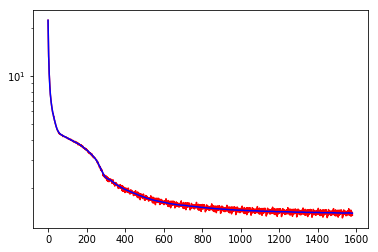

In [10]:
print("Likelihood by iteration.")

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [11]:
print("Result on test (negative log likelyhood): ", test_loss)

Result on test (negative log likelyhood):  1.2995365858078003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



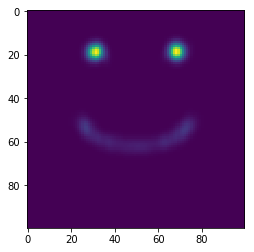

In [12]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float()
pdf = model(samples).detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

Здесь можно заметить, как по уголкам рта там, где глаза уже закончились, возможно, что распределение от глаз влияет науголки губ. Ещё возможно, что на уголках губ мы имеем отдельные распределения под них, которые пересекаются с распределением основных губ и мы получаем такое наложение.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



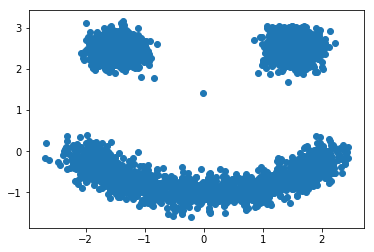

In [13]:
sample = Uniform(torch.tensor([0.0]), torch.tensor([1.0])).rsample((5000, 2))
xs, ys = model.invert(sample)
plt.figure()
plt.scatter(xs, ys)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



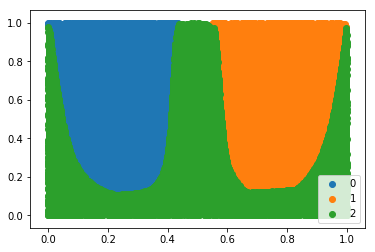

In [14]:
xs = torch.from_numpy(data_x).float()
z1, z2 = model.latent(xs)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()
plt.figure()
plt.scatter(z1[data_y == 0], z2[data_y == 0], label='0')
plt.scatter(z1[data_y == 1], z2[data_y == 1], label='1')
plt.scatter(z1[data_y == 2], z2[data_y == 2], label='2')
plt.legend()

# Задание 1.2

In [9]:
class LossAggregator:
    def __init__(self):
        self.loss = 0

class RealNVPLayer(nn.Module):
    def __init__(self, h, w, inv, s, t, losser):
        super(RealNVPLayer, self).__init__()
        ranged = np.arange(h * w).reshape(h, w)
        self.mask = torch.from_numpy(((ranged + ranged // w + inv) % 2).reshape(h * w))
        self.s = s
        self.t = t
        self.losser = losser
        
    def forward(self, x):
        self.losser.loss = (1 - self.mask) * self.s(self.mask * x) + self.losser.loss
        return x * self.mask + (1 - self.mask) * (x * self.s(self.mask * x).exp() + self.t(self.mask * x))    

In [10]:
class GlowLayer(nn.Module):
    def __init__(self, size, losser):
        super(GlowLayer, self).__init__()
        self.size = size
        self.losser = losser
        self.w = nn.Parameter(torch.ones(size))
        self.b = nn.Parameter(torch.zeros(size))

    def forward(self, x):
        x = self.w * x + self.b
        log_det = torch.log(self.w.abs() + 1e-9)
        self.losser.loss += log_det
        return x

class RealNVP(nn.Module):
    def __init__(self, h, w, num_of_layers, s_gen, t_gen):
        super(RealNVP, self).__init__()
        self.h = h
        self.w = w
        layers = []
        self.losser = LossAggregator()
        for i in range(num_of_layers):
            layers.append(RealNVPLayer(h, w, i%2, s_gen(h, w), t_gen(h, w), self.losser))
            layers.append(GlowLayer(h * w, self.losser))    
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
        
    def forward(self, batch):
        batch = torch.tensor(batch, requires_grad=False).view(-1, self.h * self.w).float()
        self.losser.loss = 0
        result = self.net(batch)
        return result, torch.sum((self.losser.loss + torch.log(result * (1 - result) + 1e-9)).view(-1, 2), dim=1)

In [11]:
class LinearRealNVP(nn.Module):
    def __init__(self, w, num_of_layers):
        super(LinearRealNVP, self).__init__()
        t_generator = lambda _, w: Multilayer([w, 100, 200, 100, w])
        s_generator = lambda _, w: nn.Sequential(t_generator(_, w), nn.Tanh())
        self.real_nvp = RealNVP(1, w, num_of_layers, s_generator, t_generator)
        
    def forward(self, batch):
        return self.real_nvp(batch)

In [13]:
def loss_function(x):
    x, s = x
    return abs(s.mean())
model = LinearRealNVP(2, 8)

In [14]:
train_losses, validate_losses, test_loss = learn(model, loss_function, 20, 1000, opt.Adam(model.parameters()))

Epoch 19/20. Iteration 78/79 Losses: train: 1.380150556564331, validate: 1.42143094539642337

Likelihood by iteration.


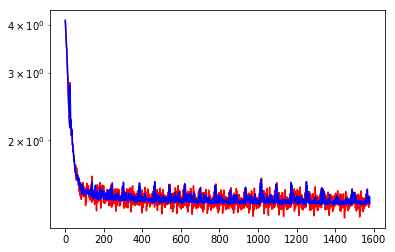

In [15]:
print("Likelihood by iteration.")

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [16]:
print("Result on test (negative log likelyhood): ", test_loss)

Result on test (negative log likelyhood):  1.2918455600738525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[[3.7785848e-15 8.9032522e-15 2.3085968e-14 ... 1.0015996e-15
  1.0777370e-15 1.1531991e-15]
 [7.6965157e-15 1.8647154e-14 4.6958765e-14 ... 1.0498756e-15
  1.1215672e-15 1.1902096e-15]
 [1.6573990e-14 3.9332473e-14 9.4547539e-14 ... 1.0777370e-15
  1.1378396e-15 1.1874252e-15]
 ...
 [7.3604696e-16 6.8167285e-16 6.2621146e-16 ... 1.0691676e-09
  2.9902034e-10 8.8114183e-11]
 [7.5602688e-16 7.0105074e-16 6.4487318e-16 ... 2.0437956e-09
  5.0502069e-10 1.3351659e-10]
 [7.7544797e-16 7.1992962e-16 6.6311891e-16 ... 4.4378021e-09
  1.0370657e-09 2.3398725e-10]]


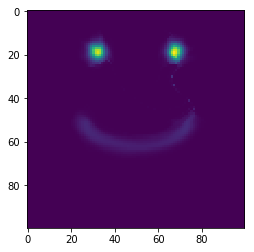

In [17]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float()
# print(model(samples)[0][2000:2010])

pdf = model(samples)[1].exp().detach().numpy().reshape(100, 100)
print(pdf)
plt.imshow(np.rot90(pdf, 1))

Заметим, что тут, в отличие от предыдущего алгоритма, губы равномерные (и алгоритм этому вполне способствует). Но зато вокруг довольно ярких глаз мы получили заметные артефакты пикселизации. Видимо, это то, как этот алгоритм представляет себе "плавный градиент".

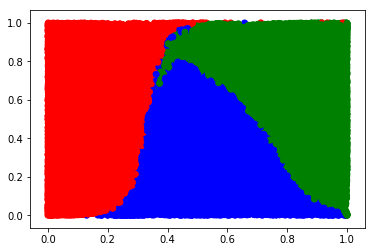

In [18]:
def display(X, y):
    colors = np.array(['red', 'green', 'blue'])
    plt.scatter(x=X[:,0], y=X[:,1], c=colors[y], cmap='cyan')
    plt.show()

cdf, pdf = model(data_x)
display(cdf.detach().numpy(), data_y)